# TP cinématique et dynamique en analyse du mouvement 1
**Charles Pontonnier - Nicolas Bideau**


## Exploration des données d'entrée



Ce petit code python a pour objectif d'investiguer la nature des données d'entrée en analyse du mouvement, en particulier les trajectoires de marqueurs en capture du mouvement et les plateformes de force.

Par la suite nous allons exploiter la librairie ezc3d. Pour installer rapidement la librairie, il vous suffit d'écrire dans un shell anaconda

conda install -c conda-forge ezc3d 

## Markerset utilisé
![alt text](markerset.png "jeu de marqueurs utilisé")

## Setup du Notebook

In [1]:
import ezc3d 
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## Ouverture du fichier et récupération des données 

In [2]:
#Ouverture du fichier
c = ezc3d.c3d('DATA/marche.c3d')
print('Nombre de marqueurs présents:',c['parameters']['POINT']['USED']['value'][0]); # nombre de marqueurs 

## Affichage du contenu des différents dictionnaires
#print(c['header'].keys())
#print(c['data'].keys())
#print(c['parameters']['FORCE_PLATFORM'].keys())

point_data = c['data']['points'] #récupération trajectoires marqueurs
point_labels=c['parameters']['POINT']['LABELS']# récupération labels marqueurs
point_rate=c['parameters']['POINT']['RATE'] # récupération fréquence mocap
analog_data = c['data']['analogs'] # récupération données analogiques
analog_labels=c['parameters']['ANALOG']['LABELS'] # récupération labels analogiques
analog_rate=c['parameters']['ANALOG']['RATE'] # récupération fréquence analogique

print('fréquence échantillonnage capture de mouvement:', point_rate['value'][0],'Hz')
print('fréquence échantillonnage données analogiques:', analog_rate['value'][0],'Hz')
# nombre d'échantillons mocap et analog
nf_mocap=len(point_data[0][0][:])
n_markers=len(point_data[0][:])
n_dims=len(point_data[:])
nf_analog=len(analog_data[0][:][:])
#reconstruction vecteur temps capture et signaux analogiques
t_point=np.linspace(0., nf_mocap/point_rate['value'][0], num=nf_mocap)
t_analog=np.linspace(0., nf_analog/analog_rate['value'][0], num=nf_analog)

print('Noms des marqueurs',point_labels)
print('Nombre de marqueurs',n_markers)
print('Nombre de dimensions',n_dims)
print('Nombre de frames',nf_mocap)




Nombre de marqueurs présents: 23
fréquence échantillonnage capture de mouvement: 300.0 Hz
fréquence échantillonnage données analogiques: 1500.0 Hz
Noms des marqueurs {'type': -1, 'description': 'Trajectory labels', 'is_locked': False, 'value': ['LKNE', 'OXSENS', 'LTOE', 'LTAR', 'LTARI', 'LHEE', 'LANI', 'LANE', 'LKNI', 'LINF', 'LFWT', 'LBWT', 'RTOE', 'RTAR', 'RTARI', 'RHEE', 'RANI', 'RANE', 'RKNI', 'RKNE', 'RINF', 'RFWT', 'RBWT']}
Nombre de marqueurs 23
Nombre de dimensions 4
Nombre de frames 1863


## Tracé de la position des marqueurs au cours de la marche

<font color='green'>**Exemple: Tracé de la position XYZ du marqueur RKNE**</font>

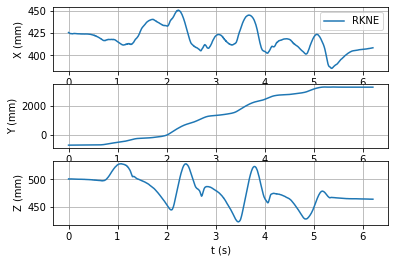

In [8]:
plt.subplot(3,1,1)
plt.grid()
plt.plot(t_point,point_data[0][19][:])

plt.xlabel('t (s)')
plt.ylabel('X (mm)')
plt.legend([point_labels["value"][19]])

plt.subplot(3,1,2)
plt.grid()
plt.plot(t_point,point_data[1][19][:])

plt.xlabel('t (s)')
plt.ylabel('Y (mm)')

plt.subplot(3,1,3)
plt.grid()
plt.plot(t_point,point_data[2][19][:])

plt.xlabel('t (s)')
plt.ylabel('Z (mm)')

plt.show()

<font color='green'>**Question 1: Tracer l'évolution du marqueur RKNI.**</font>

In [4]:
# S'inspirer des lignes ci-dessus pour le faire



## Construction des centres articulaires 

On cherche à présent à obtenir les centres articulaires des différentes articulations du modèle. Pour rappel, nous avons défini les différents centres articulaires de la manière suivante:
![alt text](centres_matrices_1.png "centres articulaires du modèle")

<font color='green'>**Question 2: Utiliser le markerset pour reconstruire les différents centres articulaires du modèle et tracer l'allure des courbes. Pour le moment on ne s'occupe pas du centre articulaire de la hanche.**</font>

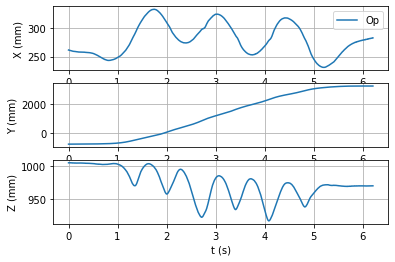

In [17]:
# le centre segmentaire (et articulaire) du pelvis est approximé par la moyenne des quatres marqueurs pelvis
Op=np.zeros((nf_mocap,3))

Op[:,0]=0.25*(point_data[0][10][:]+point_data[0][11][:]+point_data[0][21][:]+point_data[0][22][:])
Op[:,1]=0.25*(point_data[1][10][:]+point_data[1][11][:]+point_data[1][21][:]+point_data[1][22][:])
Op[:,2]=0.25*(point_data[2][10][:]+point_data[2][11][:]+point_data[2][21][:]+point_data[2][22][:])

plt.subplot(3,1,1)
plt.grid()
plt.plot(t_point,Op[:,0])
plt.xlabel('t (s)')
plt.ylabel('X (mm)')
plt.legend(['Op'])

plt.subplot(3,1,2)
plt.grid()
plt.plot(t_point,Op[:,1])
plt.xlabel('t (s)')
plt.ylabel('Y (mm)')

plt.subplot(3,1,3)
plt.grid()
plt.plot(t_point,Op[:,2])
plt.xlabel('t (s)')
plt.ylabel('Z (mm)')

plt.show()

# le centre articulaire de la hanche va faire l'objet d'un calcul spécifique ensuite

# le centre articulaire du genou est approximé par la moyenne des 2 marqueurs du genou

# le centre articulaire de la cheville est approximé par la moyenne des 2 marqueurs de la cheville

# le point situé sur le gros orteil est approximé par le marqueur gros orteil

On fournit ensuite une fonction permettant de calculer à tout instant la matrice de rotation du pelvis dans le repère monde. Cette fonction est nécessaire pour obtenir la position de la hanche dans le repère monde à tout instant.

Rappel: d'après l'extraction des données

0  ’LKNE’  
2  'LTOE’  
3  'LTAR’  
4  'LTARI’  
5  'LHEE’  
6  'LANI’  
7  'LANE’  
8  'LKNI’  
10 'LFWT’  
11 'LBWT’  
12 'RTOE’  
13 'RTAR’  
14 'RTARI’   
15 'RHEE’  
16 'RANI’  
17 'RANE’  
18 'RKNI’  
19 'RKNE’  
21 'RFWT’  
22 'RBWT' 

In [18]:
def Rp(markers):
    #matrices de rotation du pelvis
    Rp=np.zeros((3,3))

    #matrice de rotation pelvis-> monde
    zp=(markers[21,:]-markers[10,:])/np.linalg.norm(markers[21,:]-markers[10,:]) # RFWT-LFWT
    xp=(0.5*(markers[21,:]+markers[10,:])-0.5*(markers[22,:]+markers[11,:]))/np.linalg.norm(0.5*(markers[21,:]+markers[10,:])-0.5*(markers[22,:]+markers[11,:]))
    yp=np.cross(zp,xp)
    xp=np.cross(yp,zp) # attention il faut bien s'assurer d'avoir

    Rp[0,:]=[xp[0],yp[0],zp[0]]
    Rp[1,:]=[xp[1],yp[1],zp[1]]
    Rp[2,:]=[xp[2],yp[2],zp[2]]
    return Rp

In [19]:
markers=np.zeros((n_markers,n_dims-1)) #donnée temporaire contenant l'ensemble des positions de marqueurs à une frame donnée
#test pour la première frame
f=0
for i in range(0,n_markers):
    markers[i,0]=point_data[0][i][f]
    markers[i,1]=point_data[1][i][f]
    markers[i,2]=point_data[2][i][f]

Rp0=Rp(markers)
print('Rp à la frame 1=',Rp0)


Rp à la frame 1= [[ 0.09003132 -0.02766857  0.99553905]
 [ 0.98244735  0.15545452 -0.0848205 ]
 [-0.15241418  0.98570121  0.04132173]]


<font color='green'>**Question 3: Utiliser la fonction ci-dessus pour déterminer le centre articulaire de la hanche dans le repère global. Pour cela on donne, dans le repère pelvis, la position de la hanche : pOt=[-0.0074;-0.046,0.074]**</font>

[[-74]
 [-46]
 [ 74]]
[[ 0.09890186 -0.00166482  0.99507193]
 [ 0.98700659  0.10654396 -0.09839734]
 [-0.10585509  0.99187424  0.01223971]]
[[ 66.39316725]
 [-85.2209132 ]
 [-36.8872    ]]
[[ 66.39316725 -85.2209132  -36.8872    ]]
[[ 0.09890186 -0.00166482  0.99507193]
 [ 0.98700659  0.10654396 -0.09839734]
 [-0.10585509  0.99187424  0.01223971]]
[[ 66.39316725]
 [-85.2209132 ]
 [-36.8872    ]]
[[ 66.39316725 -85.2209132  -36.8872    ]]
[[ 0.09890186 -0.00166482  0.99507193]
 [ 0.98700659  0.10654396 -0.09839734]
 [-0.10585509  0.99187424  0.01223971]]
[[ 66.39316725]
 [-85.2209132 ]
 [-36.8872    ]]
[[ 66.39316725 -85.2209132  -36.8872    ]]
[[ 0.09890186 -0.00166482  0.99507193]
 [ 0.98700659  0.10654396 -0.09839734]
 [-0.10585509  0.99187424  0.01223971]]
[[ 66.39316725]
 [-85.2209132 ]
 [-36.8872    ]]
[[ 66.39316725 -85.2209132  -36.8872    ]]
[[ 0.09890186 -0.00166482  0.99507193]
 [ 0.98700659  0.10654396 -0.09839734]
 [-0.10585509  0.99187424  0.01223971]]
[[ 66.39316725]
 [-8

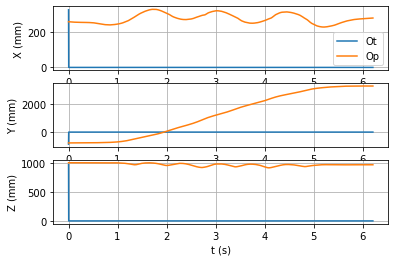

In [30]:
pOt=np.transpose([[-74,-46,74]])#création position de la hanche dans le repère local du pelvis
Ot=np.zeros((nf_mocap,3)) # création du conteneur pour la position de la hanche dans le repère monde
print(pOt)
for f in range(0,1):
    for i in range(0,n_markers):
        markers[i,0]=point_data[0][i][f] #stockage des données de marqueur à la frame f
        markers[i,1]=point_data[1][i][f]
        markers[i,2]=point_data[2][i][f]

            
plt.subplot(3,1,1)
plt.grid()
plt.plot(t_point,Ot[:,0])
plt.plot(t_point,Op[:,0])
plt.xlabel('t (s)')
plt.ylabel('X (mm)')
plt.legend(['Ot','Op'])

plt.subplot(3,1,2)
plt.grid()
plt.plot(t_point,Ot[:,1])
plt.plot(t_point,Op[:,1])
plt.xlabel('t (s)')
plt.ylabel('Y (mm)')

plt.subplot(3,1,3)
plt.grid()
plt.plot(t_point,Ot[:,2])
plt.plot(t_point,Op[:,2])
plt.xlabel('t (s)')
plt.ylabel('Z (mm)')

plt.show()

## Cinématique inverse

A présent que nous sommes en mesure de calculer tous les centres articulaires, nous sommes en mesure de récupérer les angles entre segments à l'aide de projections simples. Il suffit pour cela d'évaluer les vecteurs "y" d'un segment à l'autre et de calculer leur produit scalaire pour obtenir le cosinus de l'angle entre les deux.

<font color='green'>**Question 4: Exploiter les centres articulaires pour définir les vecteurs y de chacun des segments, et évaluer l'angle de flexion (hanche, genou, cheville) entre les segments à tout instant. Tracer ces angles.**</font>

In [ ]:
#1006-1422